In [85]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Loading in data

We start with simply loading in the data, for this case I used an excel sheet. You can also download this data from Kaggle. We then visualize the data to get a general understanding of what we are looking at.
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [86]:
pjme = pd.read_excel(r"C:\Users\Owner\Documents\RStudio\PythonData\Data\HourlyEnergy\PJME2_hourly.xlsx", index_col=[0], parse_dates=[0])

#### Visualizing the data

Here, we see the dataset where each point represents an hour in the time sheet. It tells us we are working with a cyclical pattern of flucating demand that is consistent throughout the years.

<Axes: title={'center': 'PJM East'}, xlabel='Datetime'>

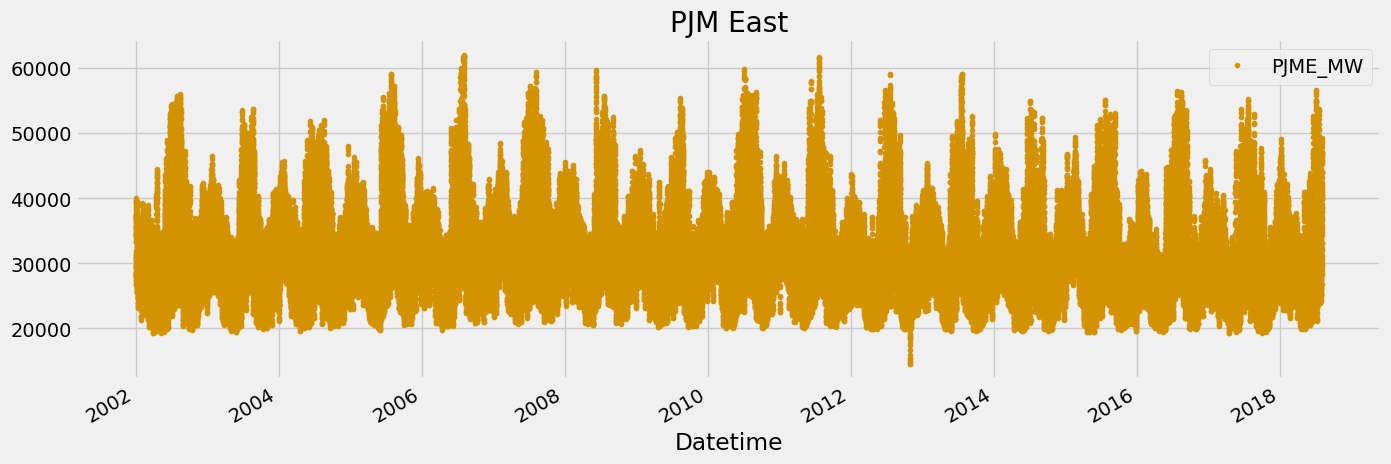

In [87]:
pjme.plot(style='.', figsize=(15,5), color="#D39200", title='PJM East')

## Splitting Data between train and test

Splitting the data into training and testing sets is the first step in building and evaluating our model. The goal is to ensure that the model is trained on one portion of the data and tested on another, which helps evaluate its performance on unseen data. For our example, we are going to aim for a 80/20 split, 80% used for training, 20% used for testing it. 

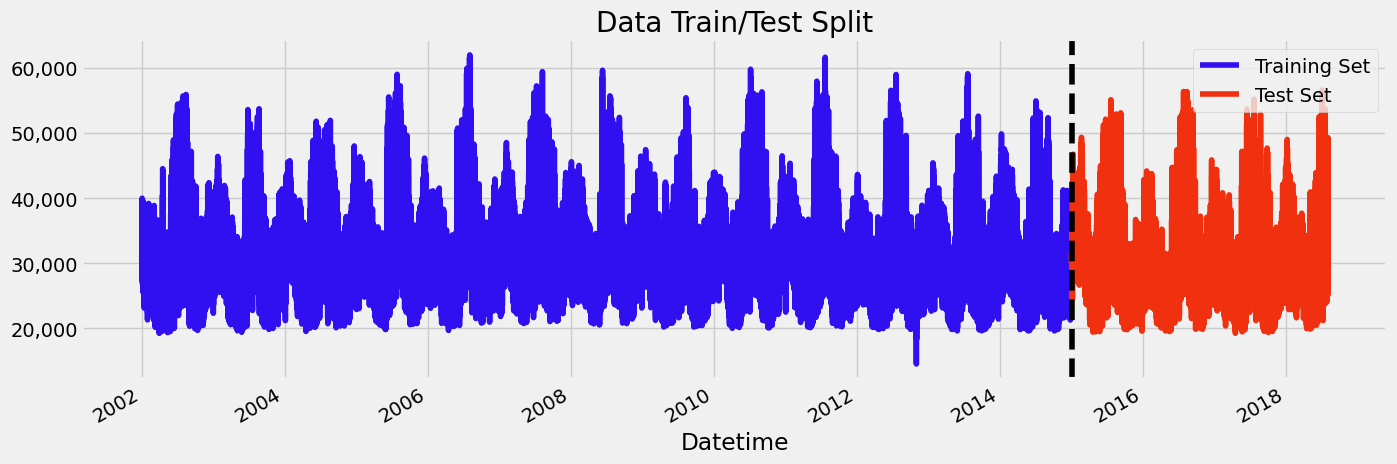

In [88]:
from matplotlib.ticker import FuncFormatter

def comma_format(x, pos):
    return f'{x:,.0f}'

pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

fig, ax = plt.subplots(figsize=(15, 5))
pjme_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color='#300FF0')
pjme_test.plot(ax=ax, label='Test Set', color='#F0300F')
ax.axvline('01-01-2015', color='black', ls='--')
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

ax.legend(['Training Set', 'Test Set'])
plt.show()


## Feature Engineering 

## Feature Engineering: Creating Time Series Features

Feature engineering is an essential step in preparing data for machine learning models. It involves transforming raw data into meaningful features that enhance the model's ability to learn patterns and make accurate predictions. This code focuses on creating time-related features from a dataset with a datetime index.

### Purpose of Feature Engineering

Time series data often contains hidden temporal patterns, such as daily, weekly, or seasonal trends. By extracting these patterns into distinct features, we can help the model better understand how time affects the target variable. 

### What Features Are Created?

1. **Hour**: The hour of the day, useful for identifying daily trends or time-of-day effects (e.g., peak energy usage in the evening).
2. **Day of the Week**: Indicates the day (0 = Monday, 6 = Sunday), capturing weekly trends such as increased activity on weekdays.
3. **Quarter**: Identifies the quarter of the year (1 to 4), which can capture seasonal effects.
4. **Month**: The month of the year (1 to 12), which can reveal monthly seasonality or trends.
5. **Year**: The year of the data, capturing long-term trends or changes over multiple years.
6. **Day of the Year**: The day number within the year (1 to 365/366), useful for detecting annual patterns.
7. **Day of the Month**: The specific day within a month (1 to 31), which might relate to monthly periodic behavior.
8. **Week of the Year**: The week number in a year, capturing broader weekly patterns.

### Why These Features Matter

- **Improved Model Accuracy**: Time features allow the model to better capture temporal relationships in the data, which is especially important in time series forecasting.
- **Interpretability**: By decomposing time into granular components, it becomes easier to analyze the relative importance of different temporal patterns.
- **Support for Complex Models**: Many machine learning models, like tree-based methods, benefit from numerical features that provide structure to the data.

### Output of the Function

- **Input Features (`X`)**: The function returns a DataFrame containing all the extracted time features, ready for model training.
- **Optional Target Variable (`y`)**: If a label column is specified, the function returns the corresponding target values alongside the features. This is useful for supervised learning tasks.

This feature engineering approach ensures the dataset is enriched with temporal insights, paving the way for more robust and interpretable predictions.

In [92]:
def create_features(df, label=None, lags=[1, 2, 3]):

    df['date'] = df.index
    
    # Time-based features
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    # Lagged features
    if label:
        for lag in lags:
            df[f'{label}_lag{lag}'] = df[label].shift(lag)

    # Drop rows with NaN values due to lagging
    df.dropna(inplace=True)

    # Selecting feature columns
    feature_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year',
                    'dayofyear', 'dayofmonth', 'weekofyear']

    if label:
        feature_cols += [f'{label}_lag{lag}' for lag in lags]

    X = df[feature_cols]

    if label:
        y = df[label]
        return X, y

    return X

X_train, y_train = create_features(pjme_train, label='PJME_MW', lags=[1, 2, 3])
X_test, y_test = create_features(pjme_test, label='PJME_MW', lags=[1, 2, 3])


# XGBoost Model

## Training and Evaluating a Model with XGBoost

XGBoost (Extreme Gradient Boosting) is a highly efficient and scalable machine learning algorithm, widely used for its performance in regression and classification tasks. This code demonstrates how to train an XGBoost model for a regression task using a structured dataset.

### Steps in the Process

1. **Data Preparation**:
   - The features and target variables for both training and testing datasets are converted into XGBoost’s `DMatrix` format (`dtrain` and `dtest`). This optimized data structure improves training efficiency.

2. **Defining Model Parameters**:
   - **`objective`**: Specifies the learning task. In this case, `reg:squarederror` is used for regression tasks.
   - **`eval_metric`**: The evaluation metric, here Root Mean Squared Error (RMSE), measures the model's prediction accuracy. Lower RMSE menas the model’s predictions are closer to the actual values, meaning better performance. Higher RMSE means the model's predictions are farther from the actual values, meaning worse performance.
   - **`n_estimators`**: Sets the maximum number of boosting rounds (trees) to 1000.   

3. **Early Stopping**:
   - To prevent overfitting and save computation time, `early_stopping_rounds=50` halts training if the test metric doesn’t improve for 50 consecutive rounds.

4. **Model Training**:
   - The `xgb.train` function is used to train the model. Training continues for a maximum of 1000 boosting rounds or until early stopping is triggered.

5. **Prediction and Evaluation**:
   - **RMSE** is computed to quantify the model's performance

### Why Use XGBoost?

- **Speed and Efficiency**: XGBoost is optimized for fast computation, making it ideal for large datasets.
- **Regularization**: It incorporates L1 and L2 regularization to reduce overfitting.
- **Early Stopping**: Automatically detects when additional training no longer improves performance, saving resources.
- **Tree-Based Learning**: Suitable for non-linear and complex relationships in the data.


By leveraging XGBoost's capabilities, this approach delivers a strong baseline for regression tasks while maintaining scalability and flexibility.


In [93]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "n_estimators": 1000,
}

evals = [(dtrain, "train"), (dtest, "test")]

# Train with early stopping
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals,
                  early_stopping_rounds=50, verbose_eval=False)

# Make predictions
y_pred = model.predict(dtest)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

c:\Users\Owner\miniforge3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 274.3274943772471


c:\Users\Owner\miniforge3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature Importance

Feature Importance measures the level of influence a feature has on the outcome of its predictions. This metric is evaluated by the Frequency Score (F-Score), it gives a straightforward measure of a feature's relevance in the model. This information lets us refine the model to focus on the factors that make the biggest difference in its prediction decisions. For our case, PJME_MW_lag1 has the highest importance (F score of 8597), followed by hour (7317). Other significant features include PJME_MW_lag3, PJME_MW_lag2, and dayofyear, all scoring above 5900.

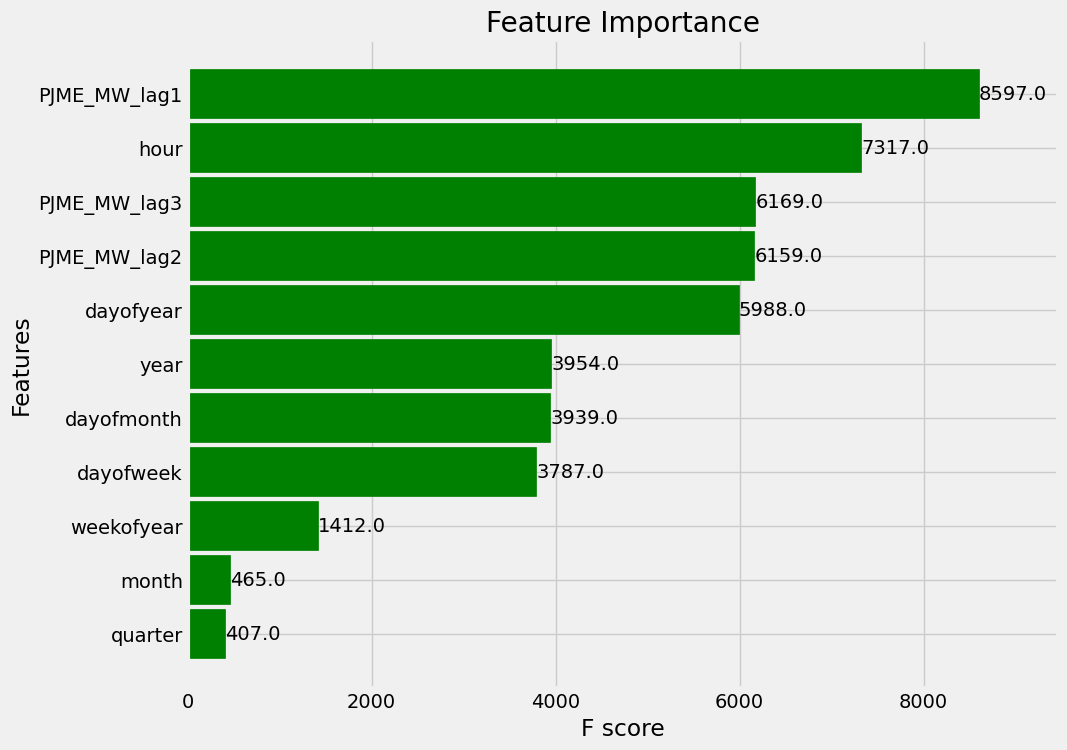

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, height=0.9, ax=ax)

for bar in ax.patches:
    bar.set_color('green')

plt.title("Feature Importance")
plt.show()

## Forecasting

We begin by converting `X_test` into a `DMatrix`, a data structure required for compatibility with XGBoost models. The trained XGBoost model then uses the `DMatrix` to generate predictions for the target variable, adding the results as a new column (`MW_Prediction`) in the test data. Finally, our predictions are combined with the training dataset (`pjme_train`) to create a one dataframe (`pjme_all`) for  analysis of actual and predicted data. This workflow allows the XGBoost model to leverage its ensemble of decision trees to apply learned patterns from the training data and produce robust predictions on unseen data.


In [95]:
dtest = xgb.DMatrix(X_test)  
pjme_test['MW_Prediction'] = model.predict(dtest)  
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

##  Results


This chart compares predicted and actual summer energy consumption from June 1 to August 1, 2018.

Here, we see three observations.

- Both lines display a clear daily pattern with peaks and troughs, reflecting fluctuations in energy demand throughout the day.
- Predictions align closely with actual values, though there are some discrepancies during periods of higher energy usage, especially in the middle of the month.
- Energy demand slightly decreases over the month, with more pronounced peaks earlier on. 

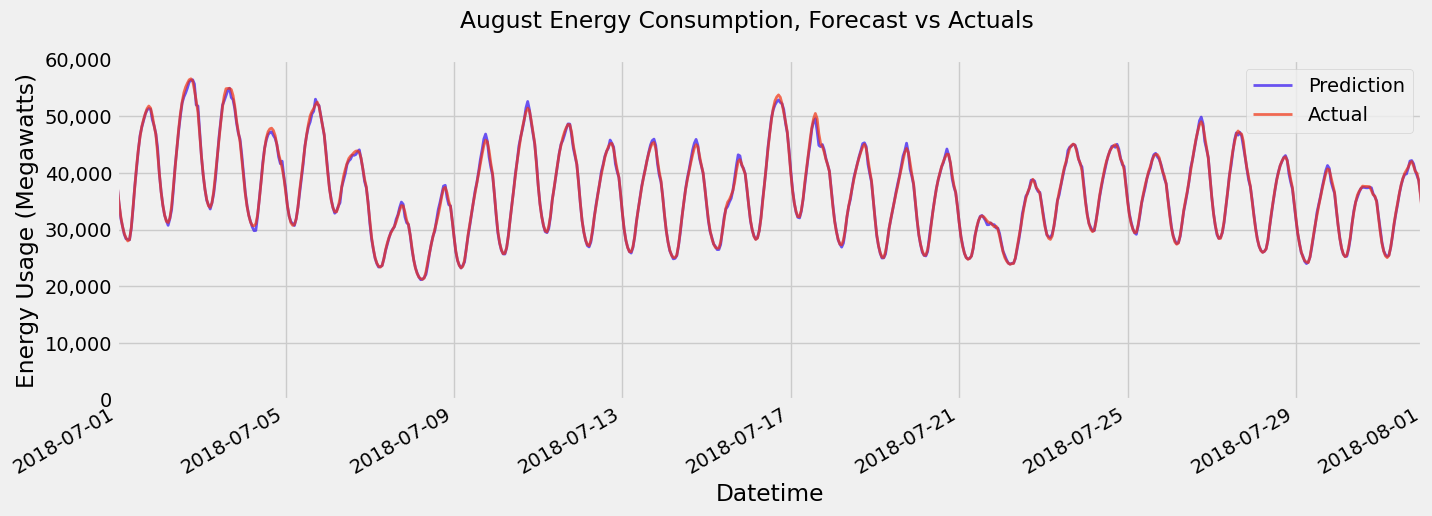

In [96]:
def comma_format(x, pos):
    return f'{x:,.0f}'


pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})


f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-', '-'],
    alpha=0.7,  
    linewidth=2, 
    color=['#300FF0', '#F0300F']  
)

ax.set_xbound(lower='07-01-2018', upper='08-01-2018')
ax.set_ylim(0, 60000)


ax.yaxis.set_major_formatter(FuncFormatter(comma_format))


ax.set_ylabel('Energy Usage (Megawatts)')


plot = plt.suptitle('August Energy Consumption, Forecast vs Actuals')

plt.show()

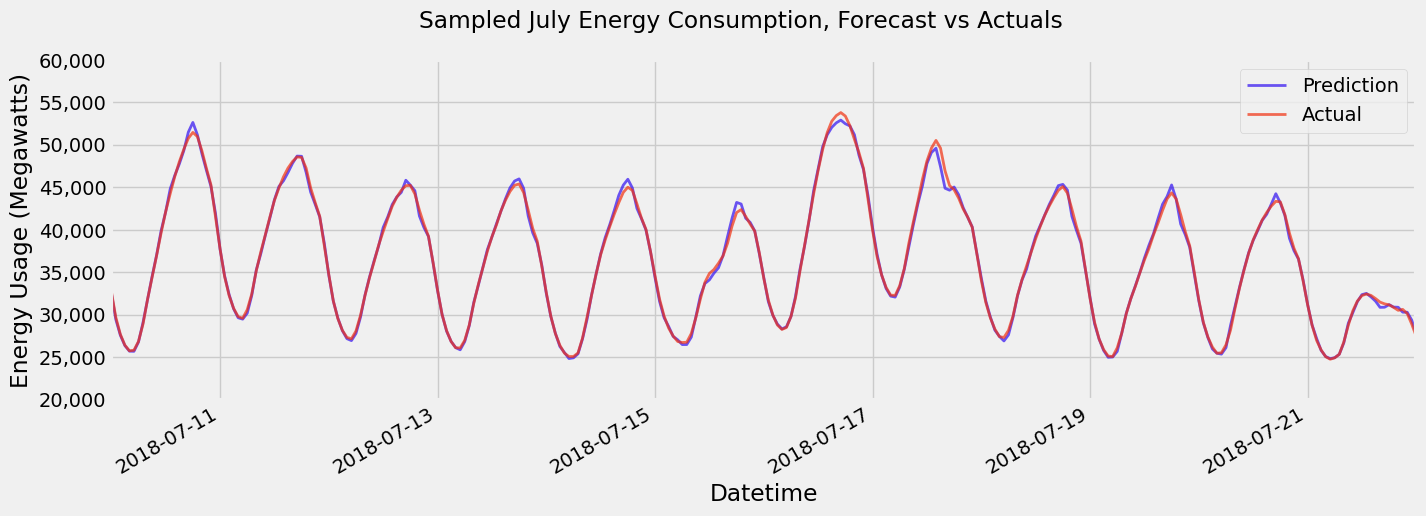

In [138]:
def comma_format(x, pos):
    return f'{x:,.0f}'


pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})


f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-', '-'],
    alpha=0.7,  # Set transparency
    linewidth=2,  # Set thinner line width
    color=['#300FF0', '#F0300F']  # Set custom colors for Prediction and Actual
)

ax.set_xbound(lower='07-10-2018', upper='07-22-2018')
ax.set_ylim(20000, 60000)

# Add comma delineation to y-axis
ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

# Add y-axis label
ax.set_ylabel('Energy Usage (Megawatts)')

# Add plot title
plot = plt.suptitle('Sampled July Energy Consumption, Forecast vs Actuals')

plt.show()

In [99]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

75255.57417129855

In [100]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

196.3271065617445

In [101]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [102]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

0.6204505945644025

In [103]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [104]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 12    28          39963.208333   40317.359375 -354.150065  429.750977
2016 7     22          41919.666667   42246.281250 -326.614339  403.426676
2017 12    31          39016.000000   39286.308594 -270.307129  551.498535
     7     19          42930.000000   43186.285156 -256.287191  340.432699
           21          43781.958333   44038.046875 -256.088298  441.602132
2015 11    27          25509.750000   25742.484375 -232.735514  271.969889
2017 2     26          26719.000000   26942.666016 -223.667155  235.498210
2018 1     13          30532.666667   30750.054688 -217.388265  309.053304
2015 7     18          35298.875000   35500.343750 -201.467611  339.348796
           19          40118.416667   40317.003906 -198.588623  309.451090

In [105]:
error_by_day.sort_values('abs_error', ascending=False).tail(10)

PJME_MW  MW_Prediction      error  abs_error
year month dayofmonth                                                   
2015 12    17          29668.333333   29707.951172 -39.616130  97.224040
2016 5     3           26982.041667   26995.125000 -13.082926  97.080973
     11    21          31992.416667   31998.556641  -6.141276  96.451009
     10    1           24848.416667   24853.146484  -4.730387  96.378337
           3           27705.583333   27696.263672   9.320068  95.094971
2015 6     6           26893.333333   26863.244141  30.089844  94.388835
     10    13          27546.166667   27499.662109  46.504639  93.104899
           28          28500.958333   28499.572266   1.386556  91.676595
2017 4     26          26909.041667   26942.431641 -33.390055  67.383057
2015 11    30          30512.791667   30506.013672   6.778809  60.012207

## Visualizations 

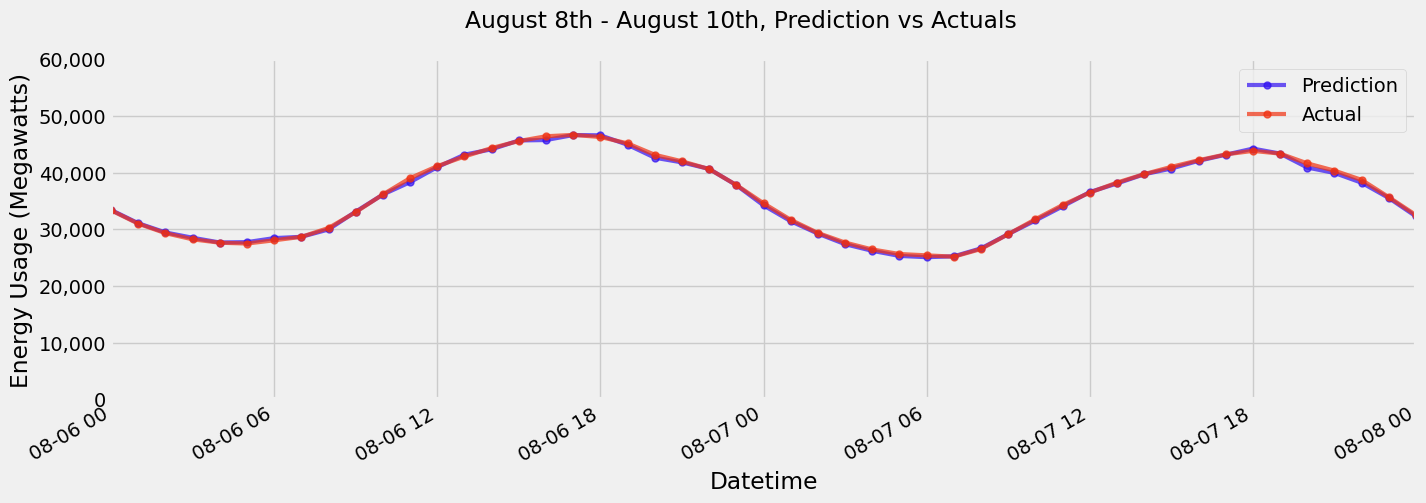

In [267]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def comma_format(x, pos):
    return f'{x:,.0f}'

pjme_all = pjme_all.rename(columns={
    'MW_Prediction': 'Prediction',
    'PJME_MW': 'Actual'
})

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

pjme_all[['Prediction', 'Actual']].plot(
    ax=ax,
    style=['-o', '-o'],  
    alpha=0.7,  
    linewidth=3,  
    markersize=5,  
    color=['#300FF0', '#F0300F']  
)

ax.set_xbound(lower='08-06-2016', upper='08-08-2016')
ax.set_ylim(0, 60000)


ax.yaxis.set_major_formatter(FuncFormatter(comma_format))


ax.set_ylabel('Energy Usage (Megawatts)')


plot = plt.suptitle('August 8th - August 10th, Prediction vs Actuals')

plt.show()


### Key Takeaways:

1. **Hourly Trends**:
   - Energy demand is lowest during the early morning hours (e.g., 3–5 AM) when activity levels are minimal.
   - Demand increases steadily throughout the day, peaking in the late afternoon and early evening (e.g., 6–8 PM).
   - After the peak, usage declines into the night.

2. **Box Plot Components**:
   - **Box**: Represents the middle 50% of values (interquartile range).
   - **Median**: The line inside the box shows the typical (middle) energy demand for each hour.
   - **Whiskers**: Indicate the range of most data points.
   - **Outliers**: Dots outside the whiskers highlight unusually high or low demand.

3. **Variability**:
   - Higher variability in the afternoon and evening reflects inconsistent demand during peak hours.
   - Early morning hours have lower and more consistent energy usage.

C:\Users\Owner\AppData\Local\Temp\ipykernel_49312\337165818.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


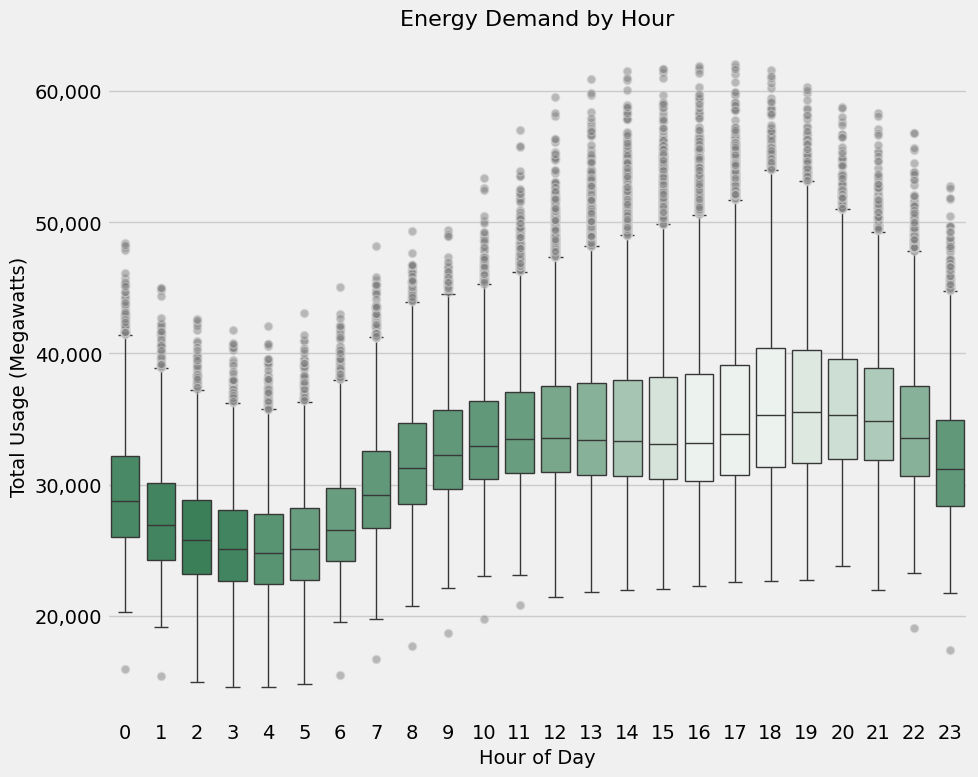

In [142]:

pjme_all = pjme_all.rename(columns={
    'Prediction': 'MW_Prediction',
    'Actual': 'PJME_MW'
})


hourly_median = pjme_all.groupby('hour')['PJME_MW'].median()
normalized_median = (hourly_median - hourly_median.min()) / (hourly_median.max() - hourly_median.min())


color_pal = sns.light_palette("seagreen", len(normalized_median))
hour_colors = {hour: color_pal[int(norm * (len(color_pal) - 1))] for hour, norm in zip(hourly_median.index, normalized_median)}


def comma_format(x, pos):
    return f'{x:,.0f}'


fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(
    data=pjme_all, 
    x='hour', 
    y='PJME_MW', 
    palette=[hour_colors[hour] for hour in pjme_all['hour'].unique()],  
    flierprops={
        'marker': 'o', 
        'markerfacecolor': 'gray', 
        'markeredgecolor': 'lightgray', 
        'alpha': 0.5
    }
)


ax.set_title('Energy Demand by Hour', fontsize=16)
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Total Usage (Megawatts)', fontsize=14)


ax.yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.tight_layout()
plt.show()



C:\Users\Owner\AppData\Local\Temp\ipykernel_49312\241544165.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


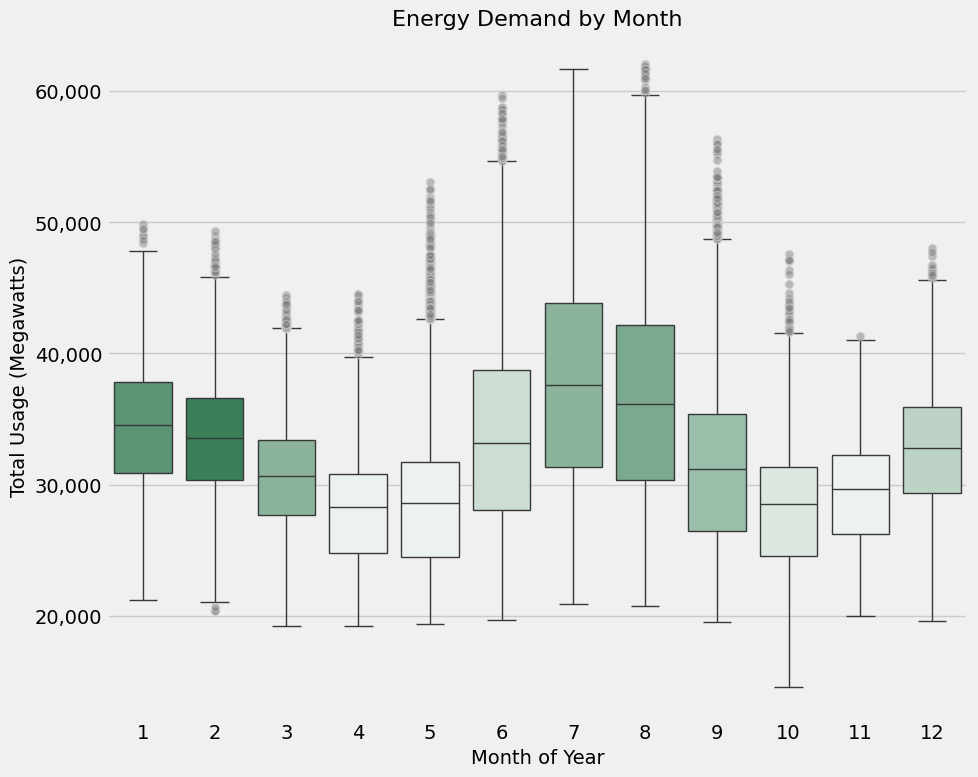

In [152]:
monthly_avg = pjme_all.groupby('month')['Actual'].mean()

normalized_avg = (monthly_avg - monthly_avg.min()) / (monthly_avg.max() - monthly_avg.min())
color_pal = sns.light_palette("seagreen", len(normalized_avg))
month_colors = {month: color_pal[int(norm * (len(color_pal) - 1))] for month, norm in zip(monthly_avg.index, normalized_avg)}

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(
    data=pjme_all, 
    x='month', 
    y='Actual', 
    palette=[month_colors[month] for month in pjme_all['month'].unique()],  
    flierprops={
        'marker': 'o', 
        'markerfacecolor': 'gray', 
        'markeredgecolor': 'lightgray', 
        'alpha': 0.5
    }
)


ax.set_title('Energy Demand by Month', fontsize=16)
ax.set_xlabel('Month of Year', fontsize=14)
ax.set_ylabel('Total Usage (Megawatts)', fontsize=14)


ax.yaxis.set_major_formatter(FuncFormatter(comma_format))


plt.tight_layout()
plt.show()

In [334]:
pjme_all.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
Datetime,,,,,,,,,,,
2018-08-03 00:00:00,35486,2018-08-03 00:00:00,0,4,3,8,2018,215,3,31,31353.884766
2018-08-02 23:00:00,38500,2018-08-02 23:00:00,23,3,3,8,2018,214,2,31,32825.929688
2018-08-02 22:00:00,41552,2018-08-02 22:00:00,22,3,3,8,2018,214,2,31,36503.222656
2018-08-02 21:00:00,43256,2018-08-02 21:00:00,21,3,3,8,2018,214,2,31,38013.160156
2018-08-02 20:00:00,44057,2018-08-02 20:00:00,20,3,3,8,2018,214,2,31,39236.679688


## Time Series Cross Validation

In [243]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = pjme_all.copy()
df = df.sort_index()

In [244]:
df.columns

Index(['Actual', 'date', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'PJME_MW_lag1', 'PJME_MW_lag2',
       'PJME_MW_lag3', 'Prediction'],
      dtype='object')

In [248]:
def create_features(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

def add_lags(df):
    target_map = df['Prediction'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [249]:
df = add_lags(df)

In [250]:
df.columns

Index(['Actual', 'date', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'PJME_MW_lag1', 'PJME_MW_lag2',
       'PJME_MW_lag3', 'Prediction', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [251]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    
    df['lag1'] = pd.to_numeric(df['lag1'], errors='coerce')
    df['lag2'] = pd.to_numeric(df['lag2'], errors='coerce')
    df['lag3'] = pd.to_numeric(df['lag3'], errors='coerce')
    return df


In [252]:
df.index.max()

Timestamp('2018-08-02 21:00:00')

In [253]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df['PJME_MW'] = None  


df['isFuture'] = False


df_and_future = pd.concat([df, future_df])
df_and_future = df_and_future.sort_index()


df_and_future = create_features(df_and_future)

def add_lags_with_handling(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag1'] = pd.to_numeric(df['lag1'], errors='coerce')
    df['lag2'] = pd.to_numeric(df['lag2'], errors='coerce')
    df['lag3'] = pd.to_numeric(df['lag3'], errors='coerce')
    return df

df_and_future = add_lags_with_handling(df_and_future)


print(df_and_future.head())
print(df_and_future.tail())


                      Actual                date  hour  dayofweek  quarter  \
2002-01-01 01:00:00  30393.0 2002-01-01 01:00:00     1          1        1   
2002-01-01 02:00:00  29265.0 2002-01-01 02:00:00     2          1        1   
2002-01-01 03:00:00  28357.0 2002-01-01 03:00:00     3          1        1   
2002-01-01 04:00:00  27899.0 2002-01-01 04:00:00     4          1        1   
2002-01-01 05:00:00  28057.0 2002-01-01 05:00:00     5          1        1   

                     month  year  dayofyear  dayofmonth  weekofyear  \
2002-01-01 01:00:00      1  2002          1           1           1   
2002-01-01 02:00:00      1  2002          1           1           1   
2002-01-01 03:00:00      1  2002          1           1           1   
2002-01-01 04:00:00      1  2002          1           1           1   
2002-01-01 05:00:00      1  2002          1           1           1   

                     PJME_MW_lag1  PJME_MW_lag2  PJME_MW_lag3  Prediction  \
2002-01-01 01:00:00       2

In [254]:
future_w_features = df_and_future.query('isFuture').copy()

In [255]:
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    
    train = create_features(train)
    test = create_features(test)

    
    for col in ['lag1', 'lag2', 'lag3']:
        train[col] = pd.to_numeric(train[col], errors='coerce')
        test[col] = pd.to_numeric(test[col], errors='coerce')


    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']
    TARGET = 'isFuture'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=500,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01
    )
    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


print(f"Scores across folds: {scores}")
print(f"Mean score: {np.mean(scores)}")


[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500
[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06632	validation_1-rmse:0.06632
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[499]	validation_0-rmse:0.00329	validation_1-rmse:0.00329
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500
[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06632	validation_1-rmse:0.06632
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[499]	validation_0-rmse:0.00329	validation_1-rmse:0.00329
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500
[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06632	validation_1-rmse:0.06632
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[499]	validation_0-r

In [256]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0033
Fold scores:[0.0033054387, 0.0032907529, 0.0032854066, 0.003285393, 0.0032853843, 0.003285376, 0.0032853654]


In [257]:

for col in ['lag1', 'lag2', 'lag3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df.fillna(0, inplace=True)


FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']
TARGET = 'isFuture'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    objective='reg:squarederror',  
    max_depth=3,
    learning_rate=0.01
)
reg.fit(
    X_all, y_all,
    eval_set=[(X_all, y_all)],
    verbose=100
)


[0]	validation_0-rmse:0.49500
[100]	validation_0-rmse:0.18119
[200]	validation_0-rmse:0.06632
[300]	validation_0-rmse:0.02428
[400]	validation_0-rmse:0.00889
[499]	validation_0-rmse:0.00329


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [258]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True


future_df['PJME_MW'] = np.nan  


df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)


In [259]:
future_w_features = df_and_future.query('isFuture').copy()

In [260]:
for col in ['lag1', 'lag2', 'lag3']:
    future_w_features[col] = pd.to_numeric(future_w_features[col], errors='coerce')


future_w_features.fillna(0, inplace=True)

print(future_w_features[FEATURES].dtypes)


future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


dayofyear      int32
hour           int32
dayofweek      int32
quarter        int32
month          int32
year           int32
lag1         float64
lag2         float64
lag3         float64
dtype: object


C:\Users\Owner\AppData\Local\Temp\ipykernel_49312\3464654439.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  future_w_features.fillna(0, inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_49312\3464654439.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_w_features.fillna(0, inplace=True)


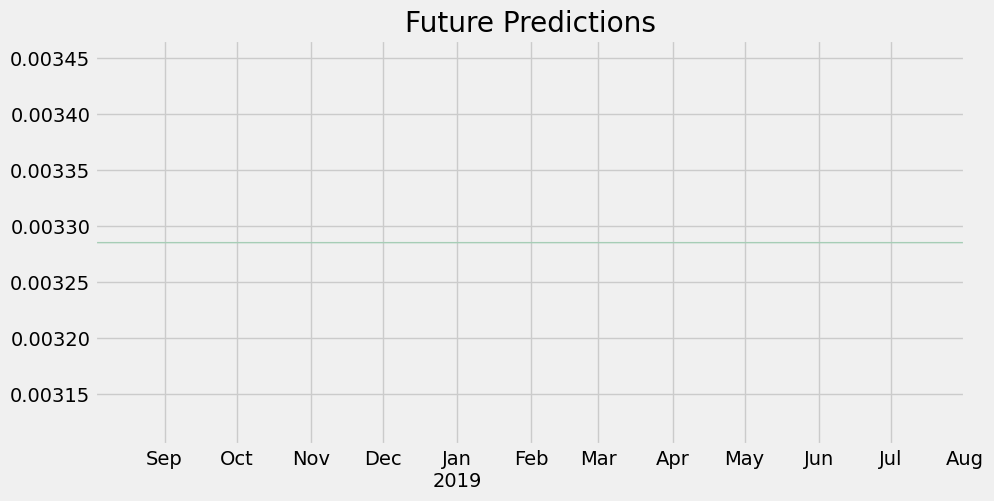

In [262]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()